In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#pandas DataFrame column and row display limits
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Defining utils for data visualizations


In [2]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df


In [3]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [4]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [5]:


def plot_categorical_variables_bar(data, column_name, figsize=(18,6), percentage_display=True, plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='xx-small'):
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)

    # Generate a color palette, one color for each category
    unique_categories = data[column_name].dropna().unique()
    palette = sns.color_palette("husl", len(unique_categories))
    color_mapping = dict(zip(unique_categories, palette))

    # Plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False).reset_index()
    data_to_plot.columns = [column_name, 'Counts']
    ax = sns.barplot(x=column_name, y='Counts', data=data_to_plot, palette=data_to_plot[column_name].map(color_mapping))

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            percentage = '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints)
            ax.text(p.get_x() + p.get_width() / 2, p.get_height(), percentage, ha='center', va='bottom', fontsize=fontsize_percent)
    
    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution of {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')

    # Plotting distribution of category for Defaulters
    if plot_defaulter:
        plt.subplot(1,2,2)
        defaulters_data = data[data.TARGET == 1]
        defaulters_count = defaulters_data[column_name].value_counts().reset_index()
        defaulters_count.columns = [column_name, 'DefaulterCounts']
        defaulters_percentage = defaulters_count.merge(data_to_plot, on=column_name, how='right')
        defaulters_percentage['Percentage'] = (defaulters_percentage['DefaulterCounts'] / defaulters_percentage['Counts']) * 100
        defaulters_percentage.fillna(0, inplace=True)
        ax_def = sns.barplot(x=column_name, y='Percentage', data=defaulters_percentage, palette=defaulters_percentage[column_name].map(color_mapping))

        for p in ax_def.patches:
            percentage = '{:1.02f}%'.format(p.get_height())
            ax_def.text(p.get_x() + p.get_width() / 2, p.get_height(), percentage, ha='center', va='bottom', fontsize=fontsize_percent)
        
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad=20)
    
    plt.show()


In [6]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all', f'Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name} (%)')
    fig.show()

In [7]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

In [8]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr(numeric_only = True)

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

# EDA

## application_train data

### Basic stats

In [9]:
application_train_df = pd.read_csv("data/application_train.csv")


In [10]:
print("Shape of the table: ", application_train_df.shape)

Shape of the table:  (307511, 122)


In [11]:
application_train_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

We see, that **application_train** table contains 121 features and TARGET variable. This table is essentially the most important since it contains the target variable as well as plenty of different features about bank's clients. It is also easy to note that some of features have a lot of missing values that must be handled somehow.

In [12]:
application_train_df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Missing values

Number of columns having NaN values: 67 columns


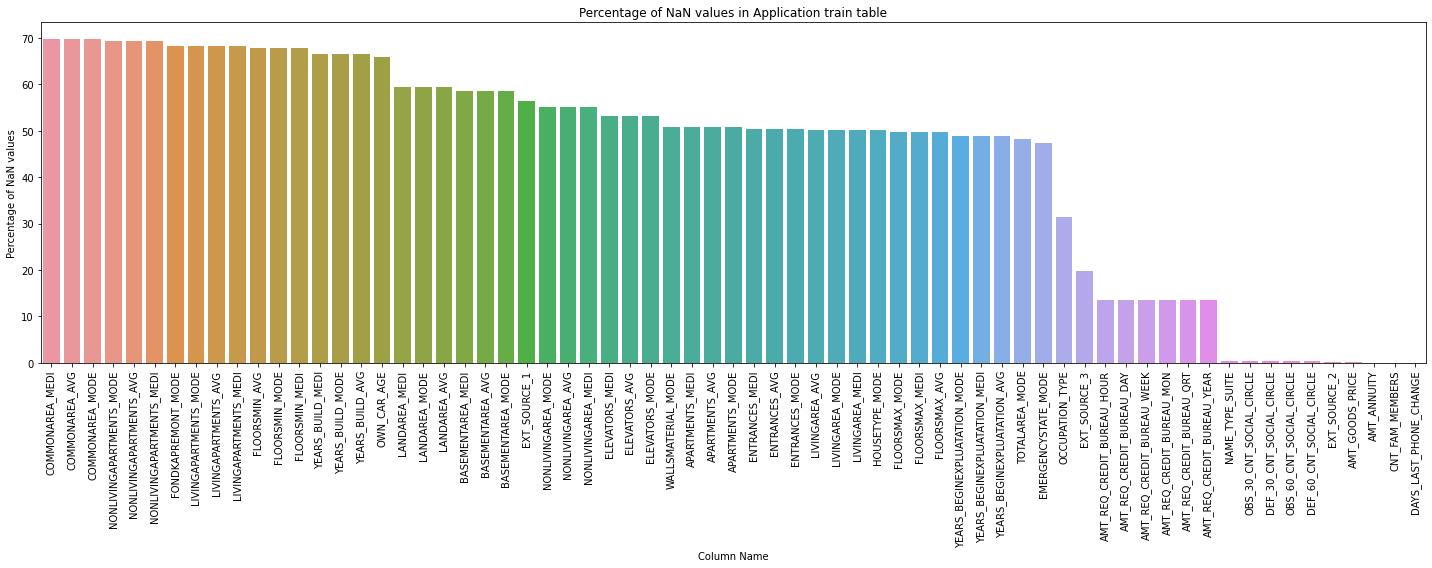

In [13]:

plot_nan_percent(nan_df_create(application_train_df), "Application train table")

Roughly 40% of features in the table contain NaNs (missing values). Moreover, there some features that have very high rate of missing values such as 50-70% of missing values in data column. A high rate of missing values in some features has to be solved using either imputing these values or dropping the column which is essentially loss of data.

### Distribution of Target


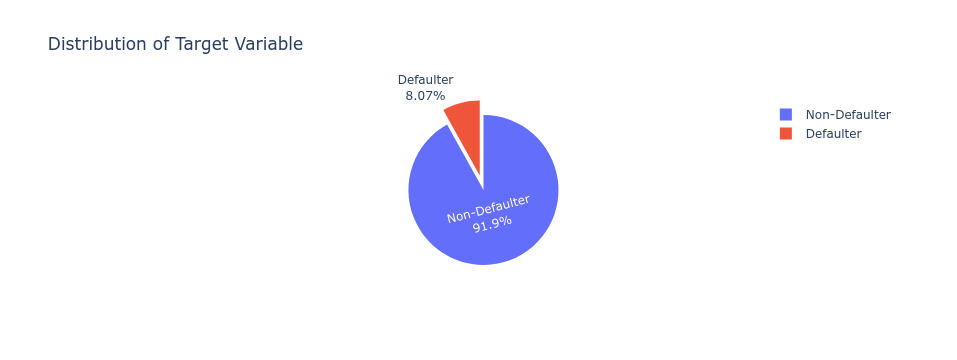

In [14]:
target_distribution = application_train_df.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent' , pull = [0,0.2])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show()


It is clearly seen that our target variable is quite **unbalanced** since ussually, most of the clients tend to return their loans.

### Correlation matrix


----------------------------------------------------------------------------------------------------


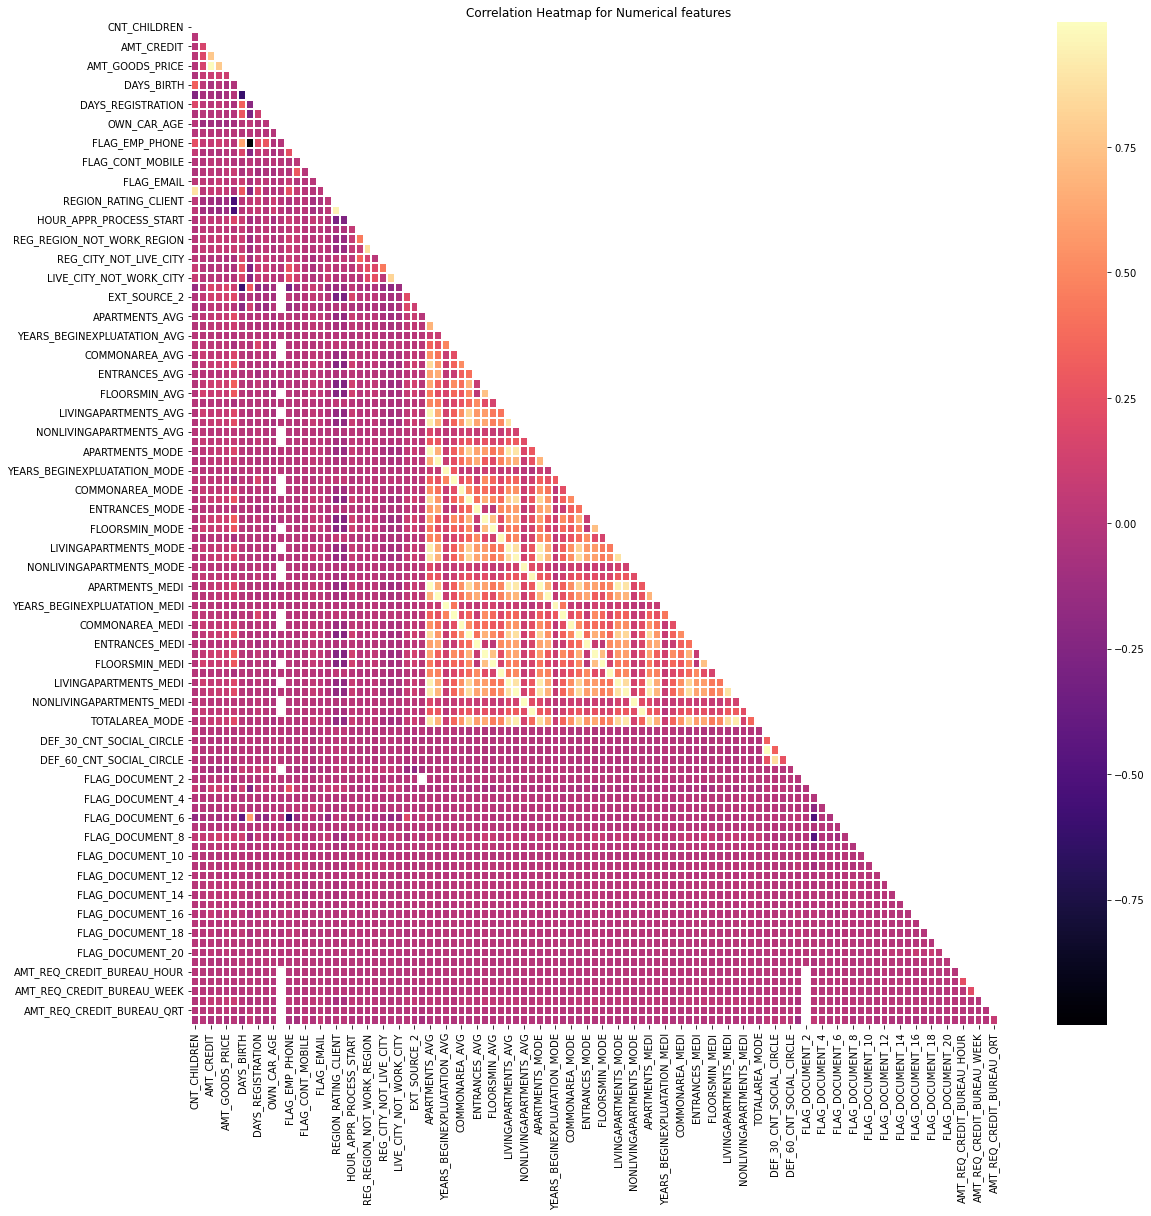

----------------------------------------------------------------------------------------------------


In [15]:
cat_columns = application_train_df.select_dtypes("object").columns.tolist()

columns_to_drop = ['SK_ID_CURR'] + list(set(cat_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train_df, columns_to_drop, figsize = (17,17), fontsize = 10, cmap = 'magma')
corr_mat.plot_correlation_matrix()



Let's observe numerical features that have largest correlation with TARGET variable

In [16]:
highest_corr_features = application_train_df.drop(cat_columns +
                    ["SK_ID_CURR"], axis=1).corr(numeric_only=True).sort_values("TARGET", ascending=False)["TARGET"][1:]


In [17]:
highest_corr_features.head(10)


DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
Name: TARGET, dtype: float64

We observe top 10 features with highest positive correlation with target

In [18]:
highest_corr_features.tail(10)[::-1]

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

We observe top 10 features with highest negative correlation with target.

To sum up, this table of correlation will be a helpful hint to understand where to look at and what features are important at first glance. 

(**Important note**: From correlations with target, I would point out that 3 most important features according to correlation are our 3 external sources of scoring EXT_SOURCE_1,2,3 that indeed shows that those external scorings indeed do some job in explaining the target)

### Comparison with categorical features

Total Number of unique categories of CODE_GENDER = 3


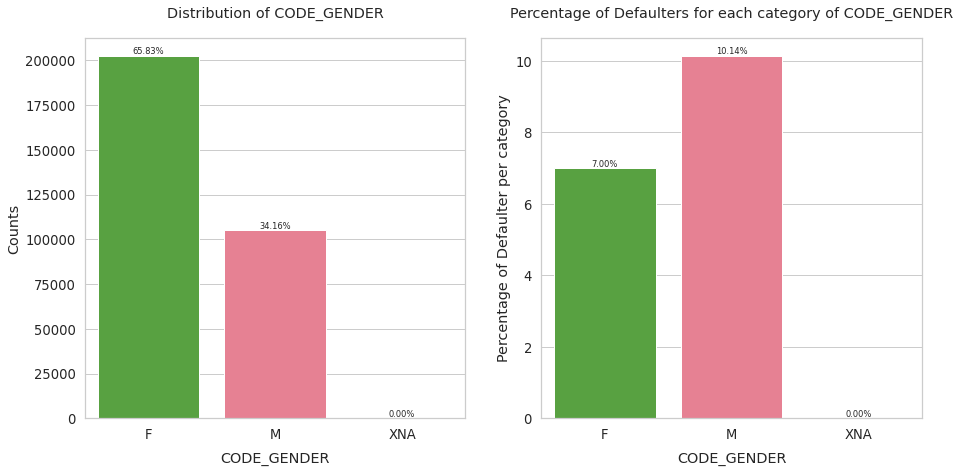

In [19]:
plot_categorical_variables_bar(application_train_df, "CODE_GENDER", figsize=(15, 7))

Total Number of unique categories of FLAG_OWN_CAR = 2


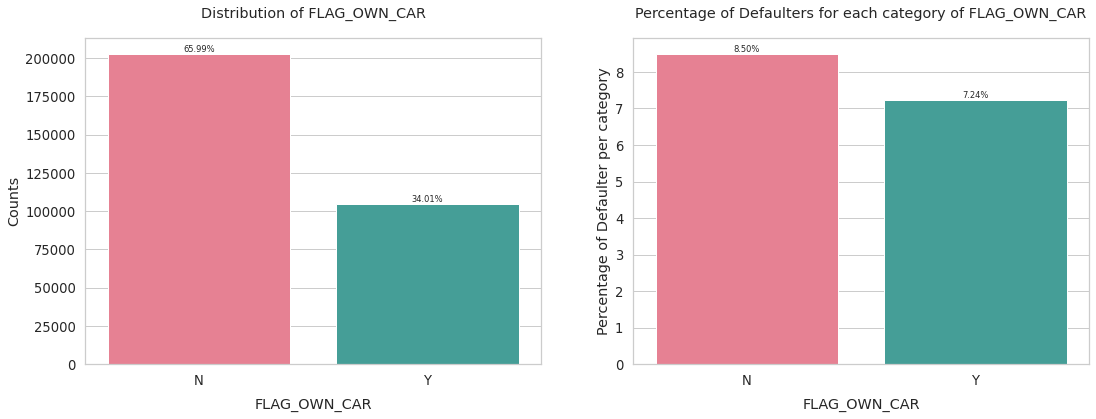

In [20]:
plot_categorical_variables_bar(application_train_df, "FLAG_OWN_CAR")

Total Number of unique categories of FLAG_OWN_REALTY = 2


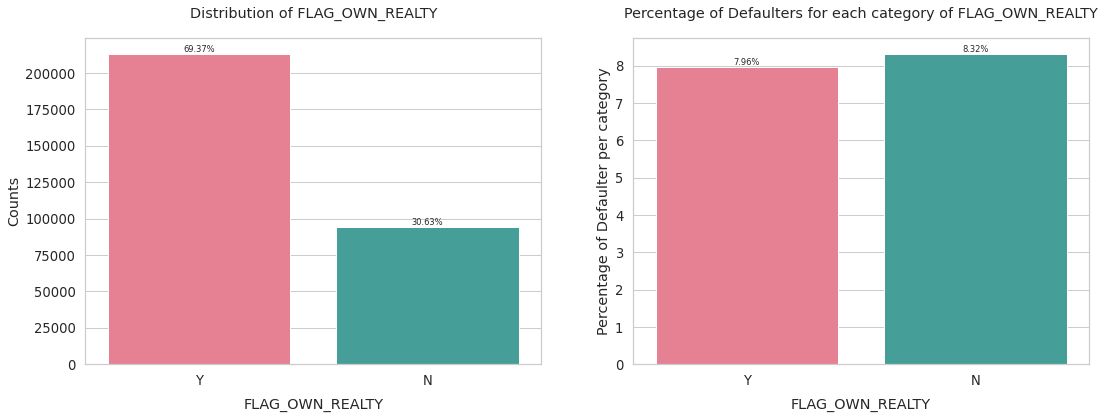

In [21]:
plot_categorical_variables_bar(application_train_df, "FLAG_OWN_REALTY")

Total Number of unique categories of NAME_EDUCATION_TYPE = 5


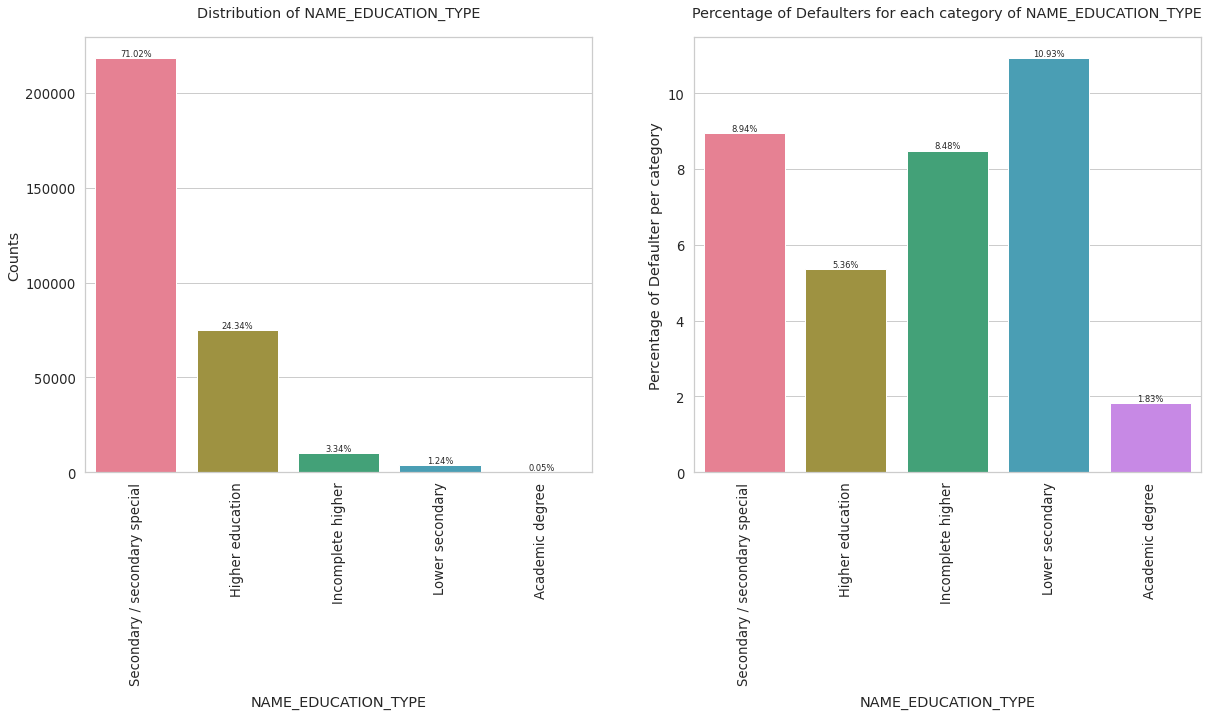

In [108]:


plot_categorical_variables_bar(application_train_df, "NAME_EDUCATION_TYPE", figsize=(20, 8), rotation=90)

Total Number of unique categories of NAME_FAMILY_STATUS = 6


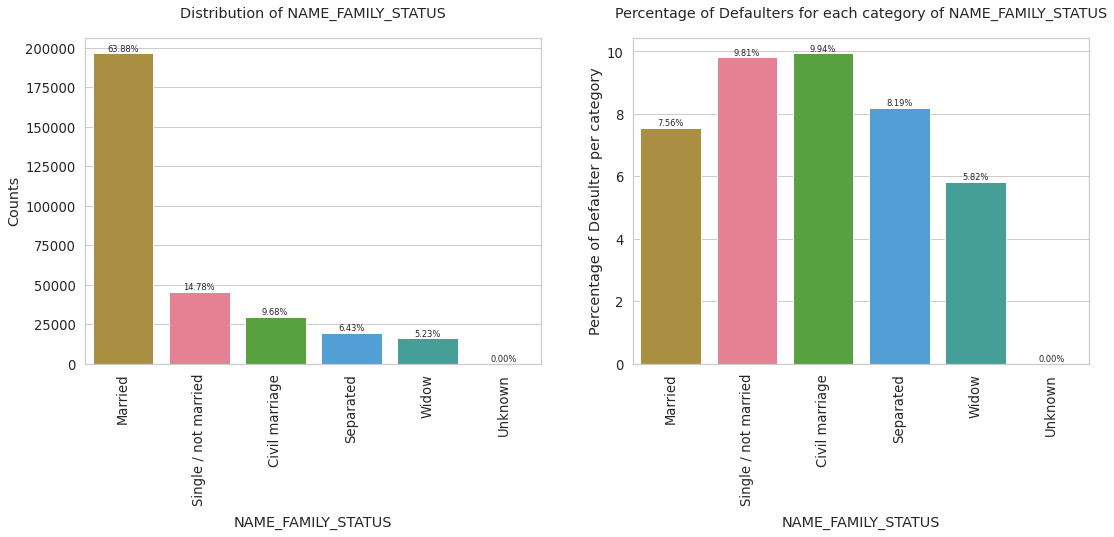

In [109]:
plot_categorical_variables_bar(application_train_df, "NAME_FAMILY_STATUS", rotation=90)

Total Number of unique categories of NAME_CONTRACT_TYPE = 2


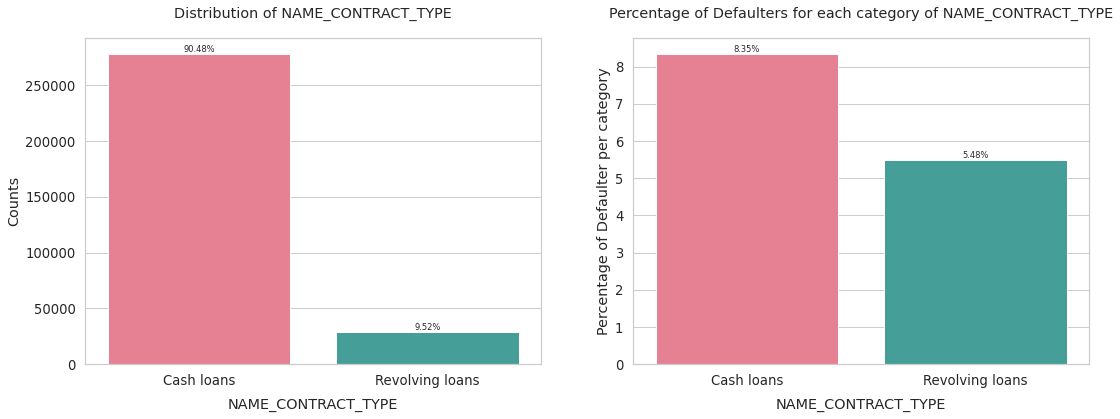

In [23]:
plot_categorical_variables_bar(application_train_df, "NAME_CONTRACT_TYPE")

Total Number of unique categories of OCCUPATION_TYPE = 19


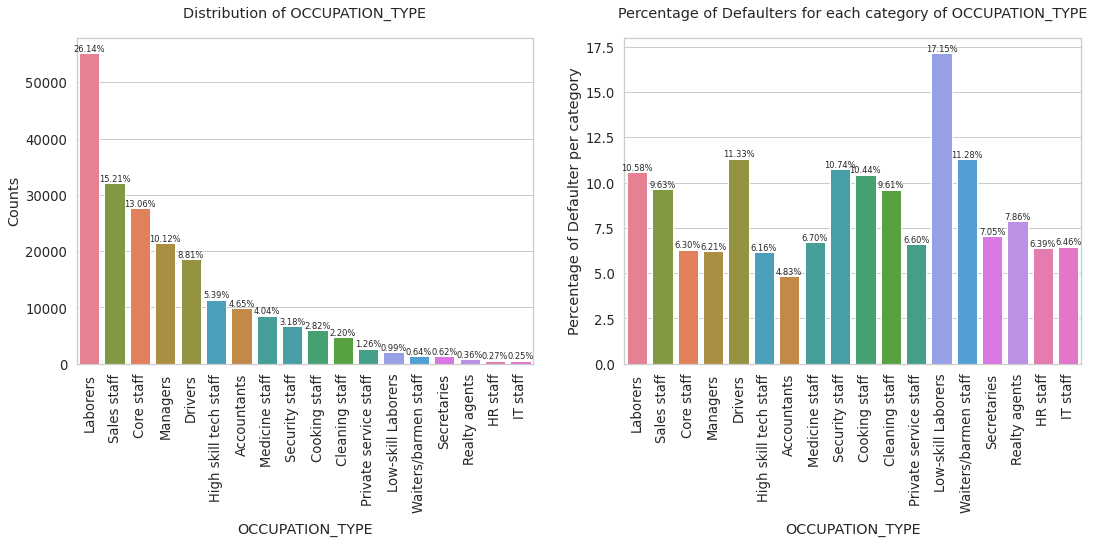

In [26]:
plot_categorical_variables_bar(application_train_df, "OCCUPATION_TYPE", rotation=90)

**Observations and notes**:
 - CODE_GENDER: Our dataset is unbalanced in terms of gender since we have more female clients (66% vs 34%). There is also a  noticable difference in fraction of defaulters between men and women. Women tend to return loans more often
 - FLAG_OWN_CAR: Probably, it is expected that people who have a car should have a better financial situation on average
 in comparison with people who have no car

 - FLAG_OWN_REALTY: Nothing interesting, the fraction of defaulters is a bit bigger in case of absense of real estate

 - NAME_EDUCATION_TYPE: This feature at first glance looks like a very good predictior for default risk since we see that fraction of defaulters increases as we move to groups of people with lower and lower level of education. At least by visualization, we can claim that the higher level of education our client have the more certainty we assign to his return.

 - NAME_FAMILY_STATUS: This feature doesn't bring much useful information although the risk of default varies a bit across different family status. For now, I don't consider this feature as very important, but still somewhat informative

 - NAME_CONTRACT_TYPE: From the plots, It is easy to notice that on average, *cash loans* default happen roughly **2** times more often that defaults on *revolving loans*. I suppose, this can be explained by the difference in these types:
Revolving credit allows you to borrow money up to a set credit limit, repay it and borrow again as needed. By contrast, installment credit lets you borrow one lump sum, which you pay back in scheduled payments until the loan is paid in full.
Perhaps, revolving loans are usually smaller sums that easier to return.

- OCCUPATION_TYPE: I should say that this feature also looks quite useful and interesting since we can see how default rate varies across different types of occupation. Workers on low-skill positions tend to be less educated and financially successful in general which leads to higher risk of something going wrong in their life and potential default. So, such  a distribution makes sense for me. As a note, I can emphasize, that *low-skill staff and waiters* categoris have the highest fraction of defaulters whereas *high-tech staff, accountants and managers* tend to return money on a regular basis